## POSTPROECESSING

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# !pip install leidenalg==0.7.0

In [4]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from MODULES.utilities import load_obj
import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time
from typing import List, Tuple

## Helper function

In [95]:
def show_sweep_movie(suggestion: Suggestion,
                     raw_image: numpy.ndarray,
                     figsize: Tuple[int,int] = (12,12),
                     interval: int = 50,
                     nbins=10,
                     hist_range=(0,200)):
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    ax_video = axs[0,0]
    ax_image = axs[0,1]
    ax_graph = axs[1,0]
    ax_hist = axs[1,1]
    
    # image
    ax_video.axis('off')
    im = ax_video.imshow(skimage.color.label2rgb(suggestion.sweep_seg_mask[0, ...], bg_label=0), aspect='equal')
    ax_video.set_title("title")

    # reference image
    ax_image.axis('off')
    _ = ax_image.imshow(raw_image, cmap='gray', aspect='equal')
    
    # graph
    color = 'tab:red'
    _ = ax_graph.plot(suggestion.sweep_resolution, suggestion.sweep_n_cells, '.--', label="n_cell", color=color)
    ax_graph.set_xlabel("resolution")
    ax_graph.set_ylabel('n_cell', color=color)
    ax_graph.tick_params(axis='y', labelcolor=color)
    ax_graph.legend()
    ax_graph.grid()

    ax_graph_2 = ax_graph.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    _ = ax_graph_2.plot(suggestion.sweep_resolution, suggestion.sweep_iou, '-', label="iou", color=color)
    ax_graph_2.set_ylabel('iou', color=color)
    ax_graph_2.tick_params(axis='y', labelcolor=color)
    ax_graph_2.legend()
    
    # histogram of sizes (excluding background cluster)
    _ = ax_hist.hist(suggestion.sweep_sizes[0][1:], range=hist_range, density=False, bins=nbins)
    ax_hist.set_title("title")
        
    plt.tight_layout()
    plt.close()
    
    def init():
        im.set_data(suggestion.sweep_seg_mask[0, ...])
        ax_video.set_title("title")
        ax_hist.hist(suggestion.sweep_sizes[0][1:], range=hist_range, density=False, bins=nbins)
        
    def animate(i):
        title = 'index={0:3d} res={1:.3f} ncell={2:2d}'.format(i,suggestion.sweep_resolution[i],
                                                                 suggestion.sweep_n_cells[i])
        ax_video.imshow(skimage.color.label2rgb(suggestion.sweep_seg_mask[i, ...], bg_label=0))
        ax_video.set_title(title)
        ax_hist.clear()
        ax_hist.hist(suggestion.sweep_sizes[i][1:], range=hist_range, density=False, bins=nbins)
        ax_hist.set_title("PDF cell size")
        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=suggestion.sweep_seg_mask.shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

def plot_sweep_comparison(keys: str, 
                          sweep1: Suggestion, 
                          sweep2: Optional[Suggestion] = None, 
                          sweep3: Optional[Suggestion] = None,
                          sweep4: Optional[Suggestion] = None,
                          index: Optional[int] = None,
                          **kargs):
    """ kargs can include:
        density=True, bins=50, range=(10,100)
    """
    
    fig, axs = plt.subplots(figsize=(12,6))
    
    if keys == "sweep_sizes":
        assert index is not None
        n = len(getattr(sweep1,keys))
        axs.set_title("Sizes fo the foreground objects")
        
        tmp = numpy.array((getattr(sweep1,keys)[index][1:],
                        getattr(sweep2,keys,[-100,-100]*n)[index][1:],
                        getattr(sweep3,keys,[-100,-100]*n)[index][1:],
                        getattr(sweep4,keys,[-100,-100]*n)[index][1:]), dtype=object, copy=False)

        _ = axs.hist(tmp, label=["sweep1","sweep2","sweep3","sweep4"], **kargs)
        axs.legend()
        axs.set_xlabel('resolution parameter')
        axs.set_ylabel(keys)
        
        axs.grid()
        axs.legend()
        
        
    else:
        # all the rest is separate
        axs.plot(sweep1.sweep_resolution,getattr(sweep1,keys), '-', label="sweep1",color="blue")
        if sweep2 is not None:
            axs.plot(sweep2.sweep_resolution,getattr(sweep2,keys), 'x--', label="sweep2",color="red")
        if sweep3 is not None:
            axs.plot(sweep3.sweep_resolution,getattr(sweep3,keys), 'o-', label="sweep3",color="green")
        if sweep4 is not None:
            axs.plot(sweep4.sweep_resolution,getattr(sweep4,keys), '.--', label="sweep4",color="black")
        
        axs.set_xlabel('resolution parameter')
        axs.set_ylabel(keys)
        axs.grid()
        axs.legend()

In [89]:
def plot_mask_image_overlay(seg_mask: numpy.ndarray, 
                            raw_image: numpy.ndarray, 
                            window: Optional[tuple] = None, 
                            figsize: tuple = (24,24)):
    
    if window is not None:
        min_row, min_col, max_row, max_col = window 
        seg_mask = seg_mask[min_row:max_row, min_col:max_col]
        raw_image = raw_image[min_row:max_row, min_col:max_col]
    
    figure, ax = plt.subplots(ncols=3, figsize=figsize)
    ax[0].imshow(skimage.color.label2rgb(label=seg_mask, bg_label=0))
    ax[1].imshow(skimage.color.label2rgb(label=seg_mask, image=raw_image, alpha=0.25, bg_label=0))
    ax[2].imshow(raw_image, cmap='gray')

In [90]:
def plot_tiling(tiling: Segmentation, 
                window: Optional[tuple] = None, 
                figsize: tuple = (24,24)):
    
    if window is None:
        min_row, min_col, max_row, max_col = None, None, None, None
    else:
        min_row, min_col, max_row, max_col = window 
        
    fig, axs = plt.subplots(ncols=3, figsize=figsize)
    axs[0].imshow(tiling.raw_image[0,0,min_row:max_row, min_col:max_col].cpu())
    axs[1].imshow(tiling.fg_prob[0,0,min_row:max_row, min_col:max_col].cpu())
    axs[2].imshow(skimage.color.label2rgb(tiling.integer_mask[0,0,min_row:max_row, min_col:max_col].cpu().numpy(), bg_label=0), aspect='equal')
    axs[0].set_title("raw image")
    axs[1].set_title("fg prob")
    axs[2].set_title("sample segmentation")

# Import files

In [128]:
#tiling_file = "/home/jupyter/REPOS/spacetx-research/NEW_ARCHIVE/merfish_aug_5_v1/tiling_aug7_radius5.pt"
#tiling_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/merfish_aug_5_v1/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_segment_june27_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v6/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100.pt"
tiling_file = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100_LARGE.pt"

# Comparison of criteria using small images

In [129]:
tiling = load_obj(tiling_file)

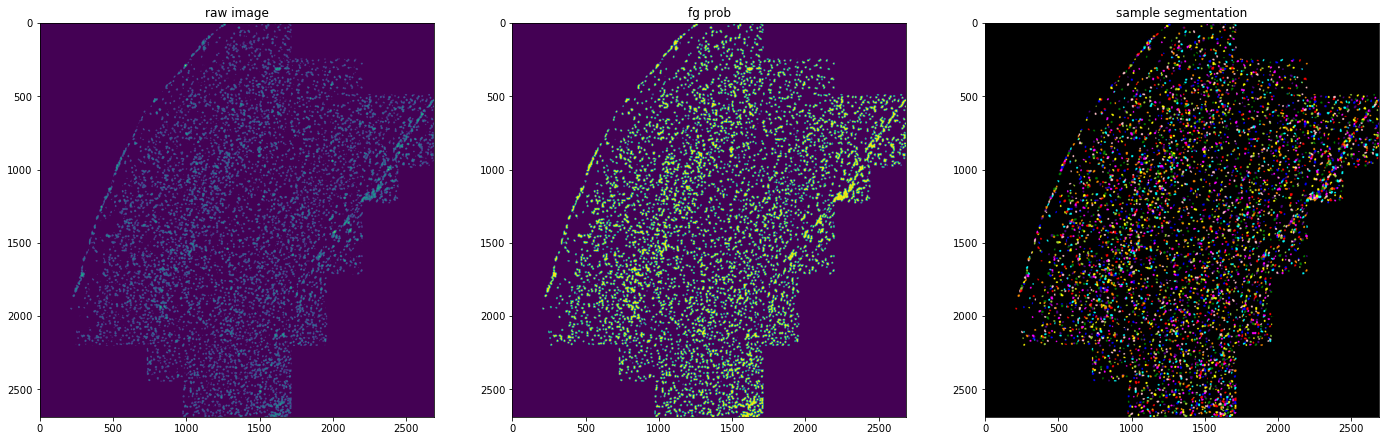

In [132]:
#window = (1000, 2000, 1200, 2200)
window = None
plot_tiling(tiling, window)

### Graph with normalization

In [134]:
g1 = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
print(g1.graph["total_nodes"])
print(g1.graph["total_edge_weight"])

Done building the graph
885682
417412.21875


In [11]:
sweep_cpm1 = g1.suggest_resolution_parameter(window = window, 
                                             min_size = 20,
                                             max_size = None,
                                             cpm_or_modularity = "cpm",
                                             each_cc_separately = False,
                                             sweep_range = numpy.arange(0.2,10.0,0.2)) 
sweep_modularity1 = g1.suggest_resolution_parameter(window = window, 
                                                  min_size = 20,
                                                  max_size = None,
                                                  cpm_or_modularity = "modularity",
                                                  each_cc_separately = False,
                                                  sweep_range = numpy.arange(0.2,10.0,0.2)) 

Done building the graph
7862
3692.69384765625
resolution sweep,   0 out of  48
resolution sweep,  10 out of  48
resolution sweep,  20 out of  48
resolution sweep,  30 out of  48
resolution sweep,  40 out of  48
resolution sweep,  48 out of  48
resolution sweep,   0 out of  48
resolution sweep,  10 out of  48
resolution sweep,  20 out of  48
resolution sweep,  30 out of  48
resolution sweep,  40 out of  48
resolution sweep,  48 out of  48


In [12]:
#sweep_cpm1.show_graph(figsize=(12,12))
#sweep_modularity1.show_graph(figsize=(12,12))
#sweep_modularity1.show_best()
#sweep_cpm1.show_best()

### Graph without normalization

In [13]:
#g2 = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=False)
#print(g2.graph["total_nodes"])
#print(g2.graph["total_edge_weight"])

In [13]:
sweep_cpm2 = g2.suggest_resolution_parameter(window = window, 
                                             min_size = 20,
                                             max_size = None,
                                             cpm_or_modularity = "cpm",
                                             each_cc_separately = False,
                                             sweep_range = numpy.arange(0.2,10.0,0.2)) 
sweep_modularity2 = g2.suggest_resolution_parameter(window = window, 
                                                  min_size = 20,
                                                  max_size = None,
                                                  cpm_or_modularity = "modularity",
                                                  each_cc_separately = False,
                                                  sweep_range = numpy.arange(0.2,10.0,0.2)) 

Done building the graph
7862
212995.09375
resolution sweep,   0 out of  48
resolution sweep,  10 out of  48
resolution sweep,  20 out of  48
resolution sweep,  30 out of  48
resolution sweep,  40 out of  48
resolution sweep,  48 out of  48
resolution sweep,   0 out of  48
resolution sweep,  10 out of  48
resolution sweep,  20 out of  48
resolution sweep,  30 out of  48
resolution sweep,  40 out of  48
resolution sweep,  48 out of  48


In [14]:
#sweep_cpm2.show_graph(figsize=(12,12))
#sweep_modularity2.show_graph(figsize=(12,12))
#sweep_modularity2.show_best()
#sweep_cpm2.show_best()

### Plot comparison of sweeps

In [91]:
sweep_cpm1._fields

('best_resolution',
 'best_index',
 'sweep_resolution',
 'sweep_mi',
 'sweep_iou',
 'sweep_delta_n',
 'sweep_seg_mask',
 'sweep_n_cells',
 'sweep_sizes')

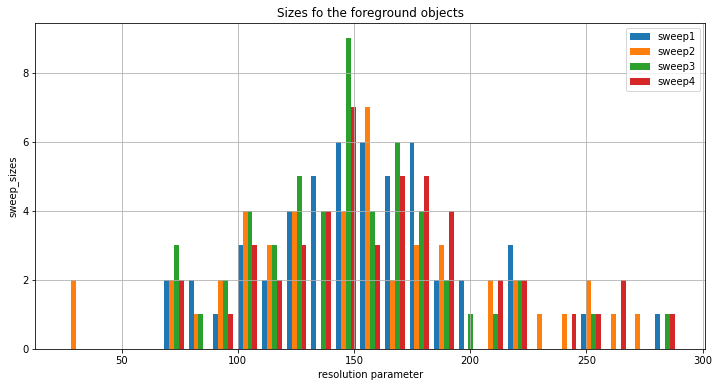

In [96]:
plot_sweep_comparison('sweep_sizes', sweep_cpm1, sweep_cpm2, sweep_modularity1, sweep_modularity2, index=-1, bins=25)

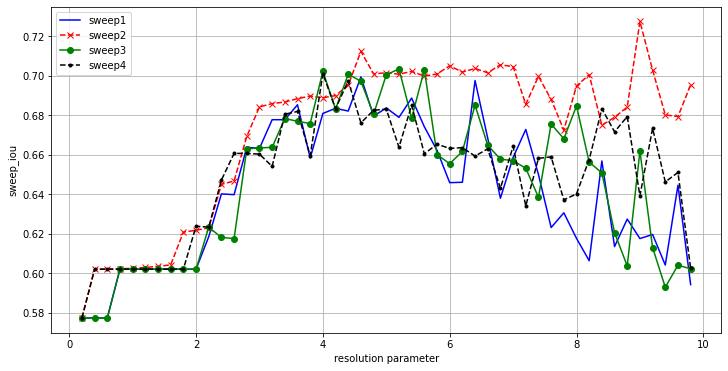

In [97]:
plot_sweep_comparison('sweep_iou', sweep_cpm1, sweep_cpm2, sweep_modularity1, sweep_modularity2)

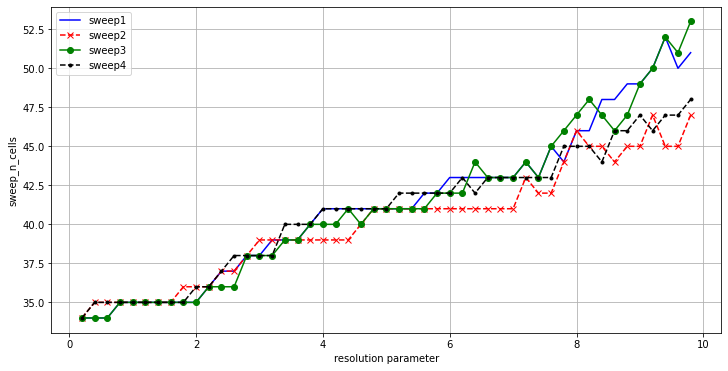

In [98]:
plot_sweep_comparison('sweep_n_cells', sweep_cpm1, sweep_cpm2, sweep_modularity1, sweep_modularity2)

### Show movie

In [108]:
raw_image = tiling.raw_image[0,0].cpu().numpy()

In [111]:
show_sweep_movie(suggestion=sweep_modularity1,
                 raw_image=raw_image,
                 figsize= (12, 12),
                 interval= 500,
                 nbins=20,
                 hist_range=(0,300))

### Chose the best and visualize

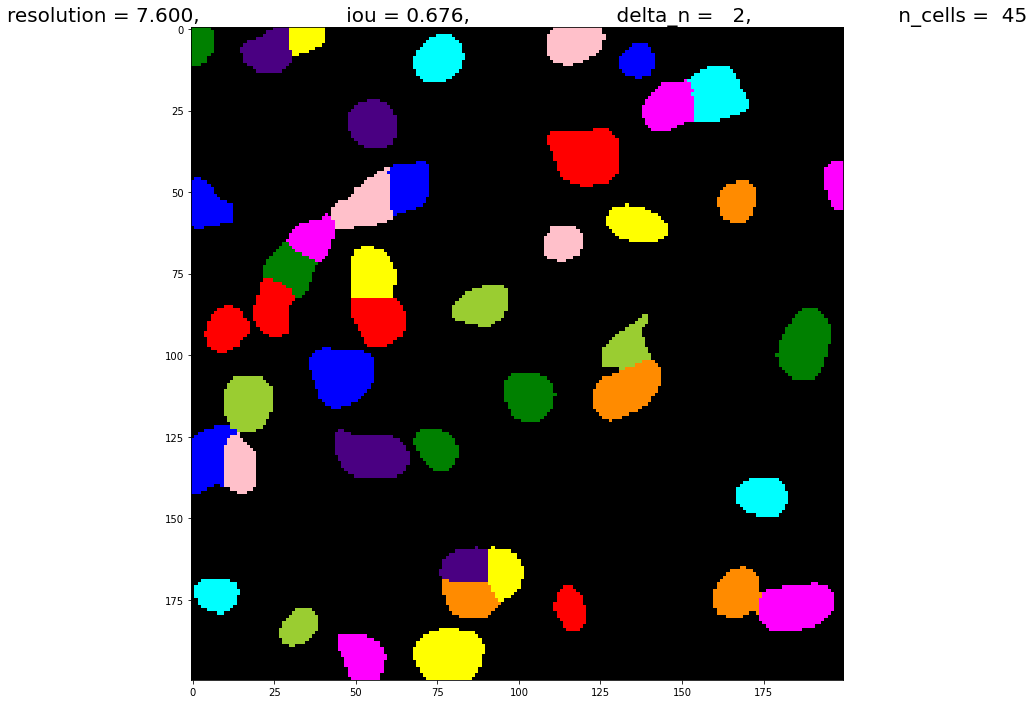

In [113]:
sweep_modularity1.show_index(index=37, figsize=(12,12))

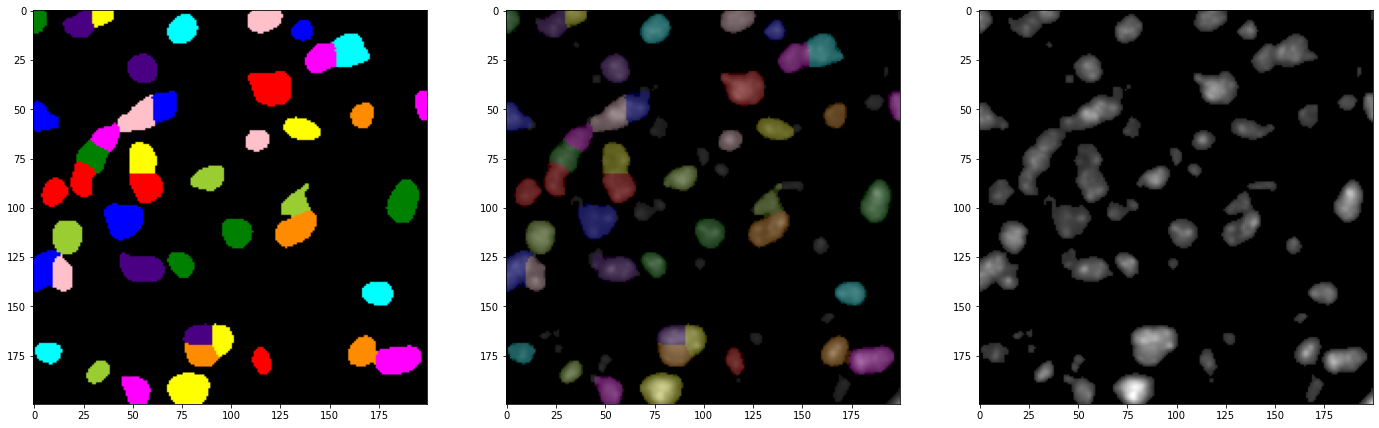

In [114]:
plot_overlay(seg_mask=sweep_modularity1.sweep_seg_mask[37], 
             raw_image=raw_image)

# Now run segmentation on the entire image

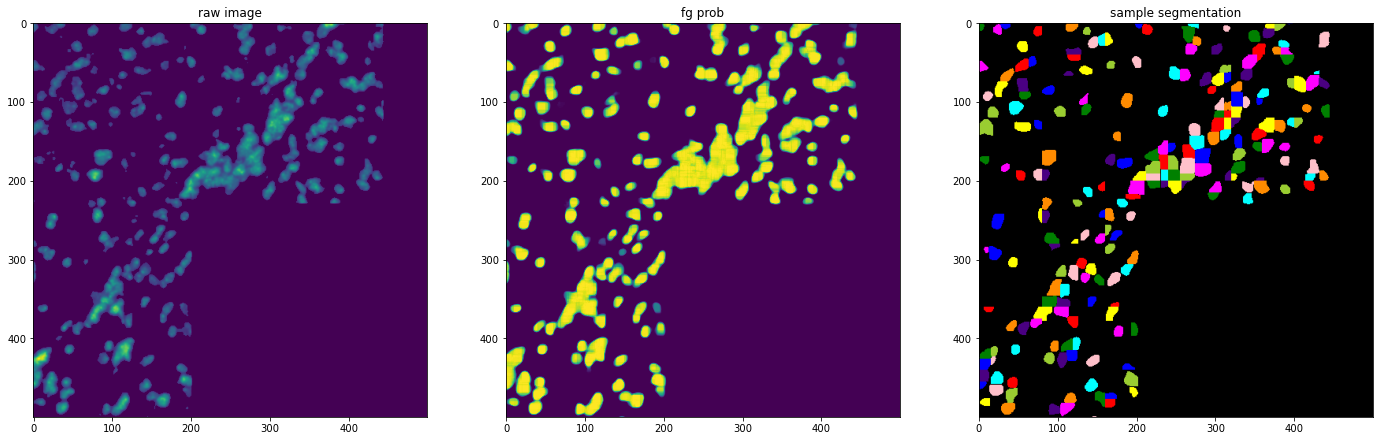

In [154]:
window = (1000, 2000, 1500, 2500)
plot_tiling(tiling, window)

In [155]:
start_time = time.time()
partition = g1.find_partition_leiden(resolution=7.6, 
                                     window=window,
                                     min_size=20, 
                                     cpm_or_modularity="modularity", 
                                     each_cc_separately=False,
                                     n_iterations=10,
                                     initial_membership=None)
print("community detection time",time.time()-start_time)

community detection time 15.278229236602783


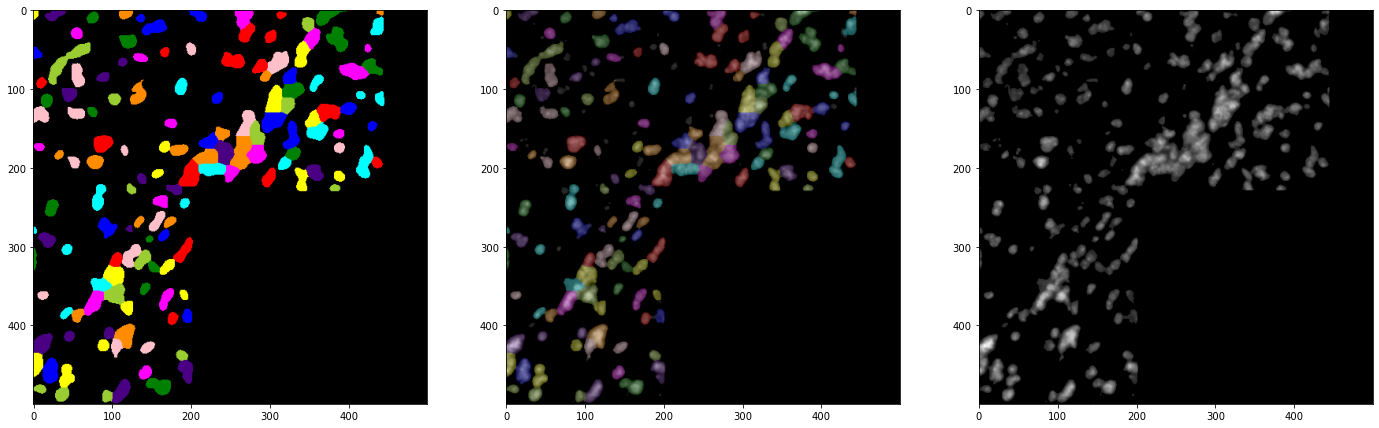

In [164]:
raw_image = tiling.raw_image[0,0].cpu().numpy()
segmask = g1.partition_2_mask(partition).cpu().numpy()

plot_mask_image_overlay(seg_mask=segmask, 
                        raw_image=raw_image,
                        window=window,
                        figsize=(24,24))

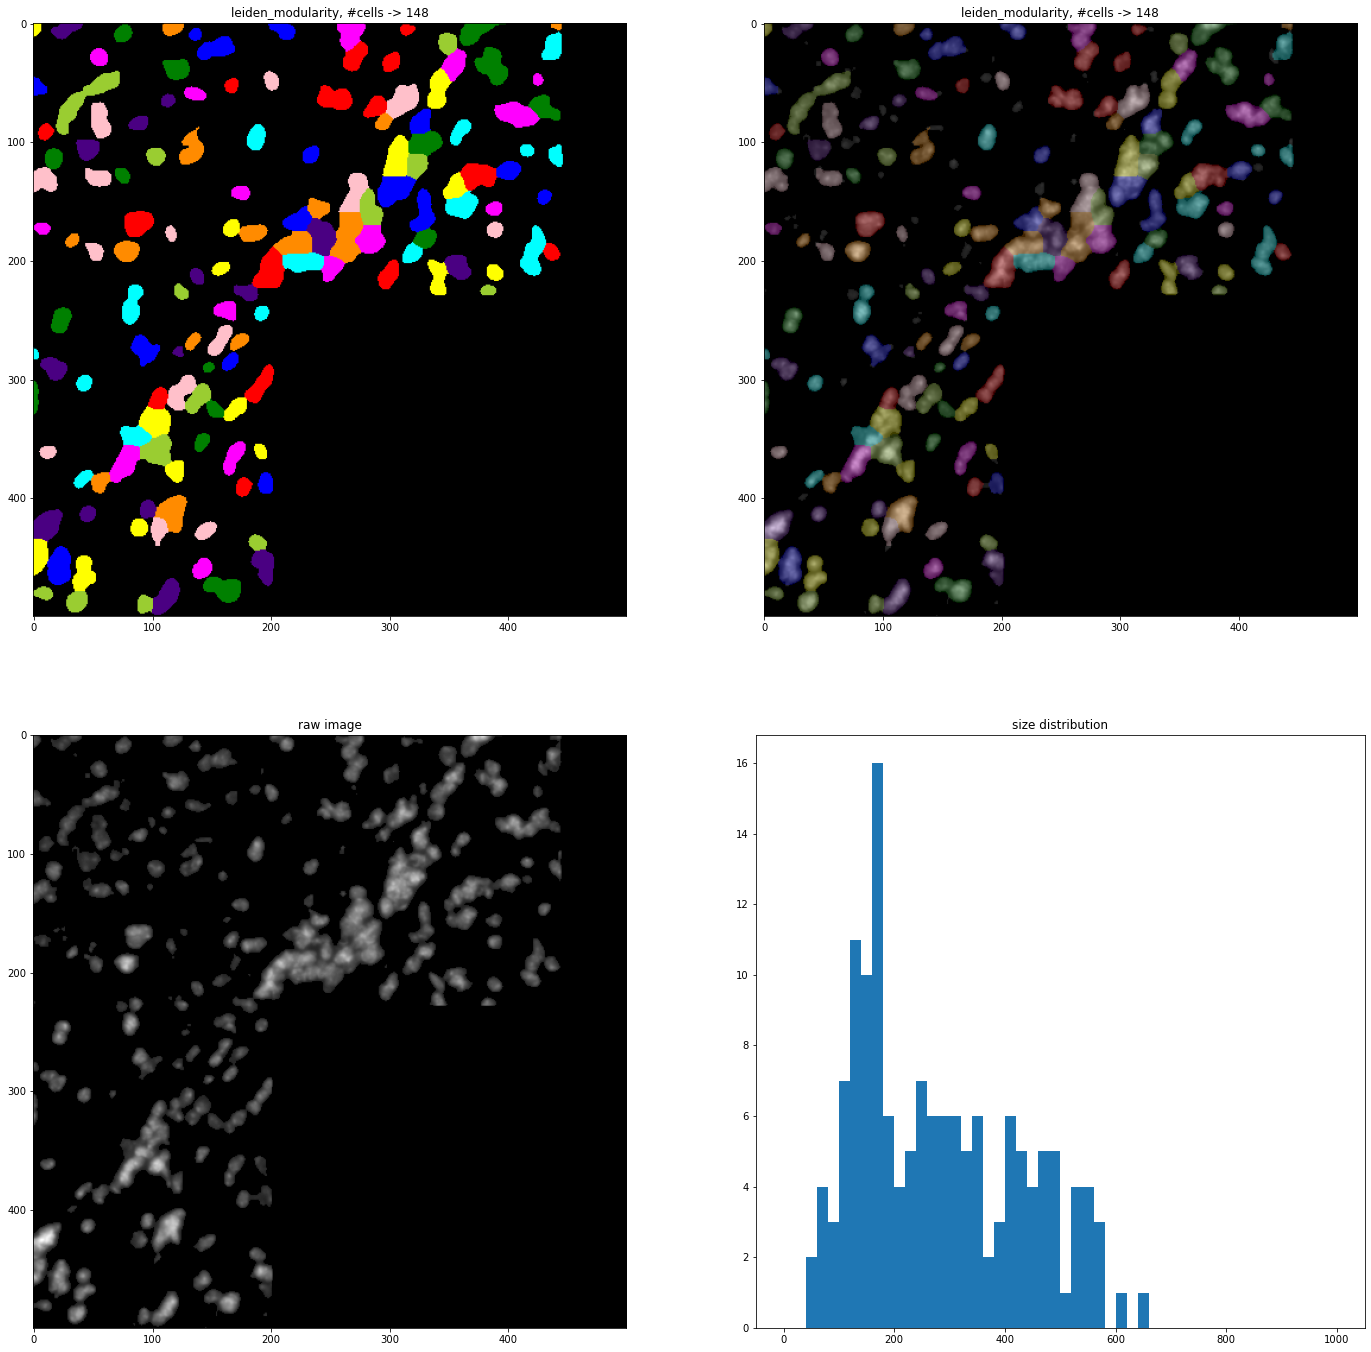

In [165]:
g1.plot_partition(partition, window=window, figsize=(24, 24), bins=50, range=(0,1000))

In [166]:
segmask = g1.partition_2_mask(partition).cpu().numpy()

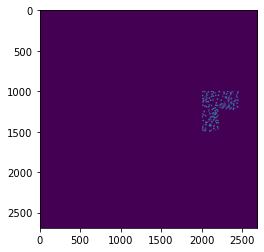

In [167]:
plt.imshow(segmask)